# Housing data exploring and model creation

## Settings and preparation

### Imports

In [50]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, StratifiedShuffleSplit,
    cross_val_score, GridSearchCV, RandomizedSearchCV)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from scipy import stats

%matplotlib inline

### Download the data

To download the data required to run this notebook execute the script 'src/data/download_housing_dataset.py' from the console. Use a module-like execution (python -m src.data.download_housing_dataset)

### Constants

In [2]:
PROJECT_ROOT_PATH = Path(os.path.abspath('')).parent
PROJECT_DATA_PATH = PROJECT_ROOT_PATH / 'data'
PROJECT_MODELS_PATH = PROJECT_ROOT_PATH / 'models'
HOUSING_DATASET_PATH = PROJECT_DATA_PATH / 'raw/housing/housing.csv'

### Load the data

In [3]:
def load_housing_data(file_path=HOUSING_DATASET_PATH):
    return pd.read_csv(file_path)

In [4]:
housing_dataset = load_housing_data()
housing_dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Exploratory analysis

In [5]:
housing_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
housing_dataset['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing_dataset.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


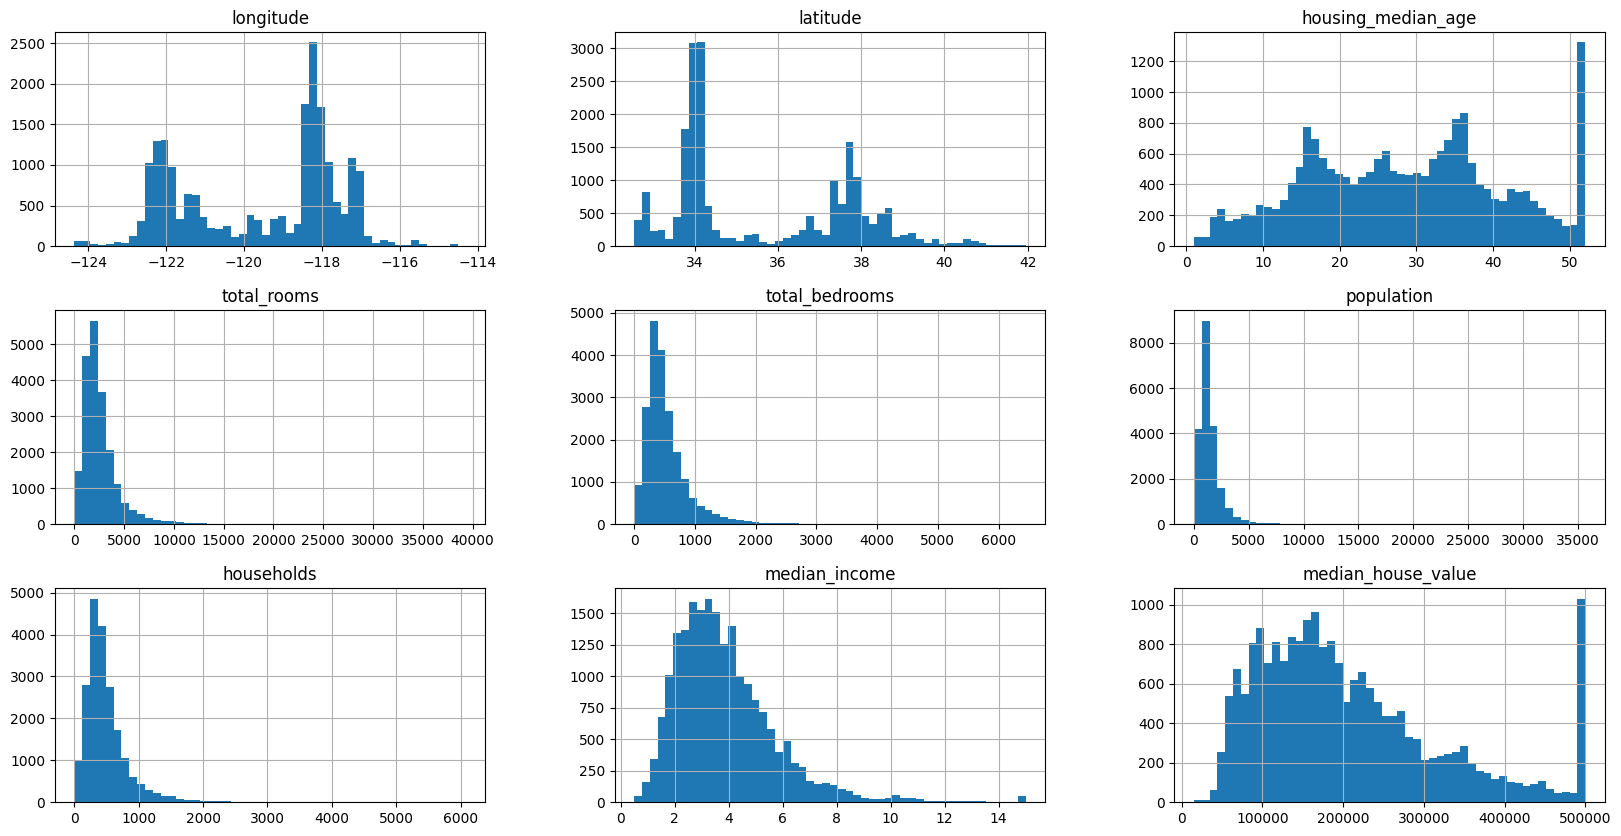

In [8]:
housing_dataset.hist(bins=50, figsize=(20, 10))
plt.show()

## Preprocessing

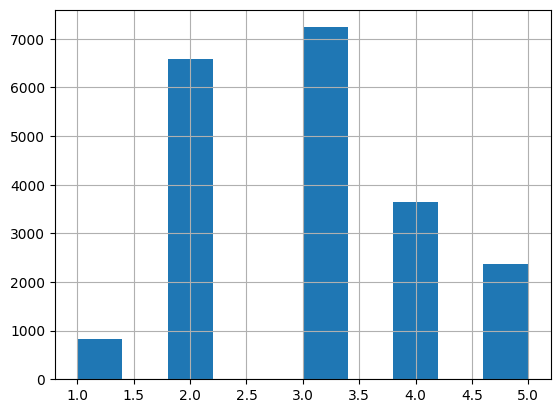

In [9]:
housing_dataset['income_category'] = pd.cut(
    housing_dataset['median_income'],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5]
)

housing_dataset['income_category'].hist()
plt.show()

### Stratified sampling

In [10]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(housing_dataset, housing_dataset['income_category']):
    strat_train_set = housing_dataset.loc[train_index]
    strat_test_set = housing_dataset.loc[test_index]

In [11]:
strat_test_set['income_category'].value_counts()

income_category
3    1447
2    1316
4     728
5     472
1     165
Name: count, dtype: int64

In [12]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_category', axis=1, inplace=True)

### Discovering and visualizing

In [13]:
housing_exploring_set = strat_train_set.copy()

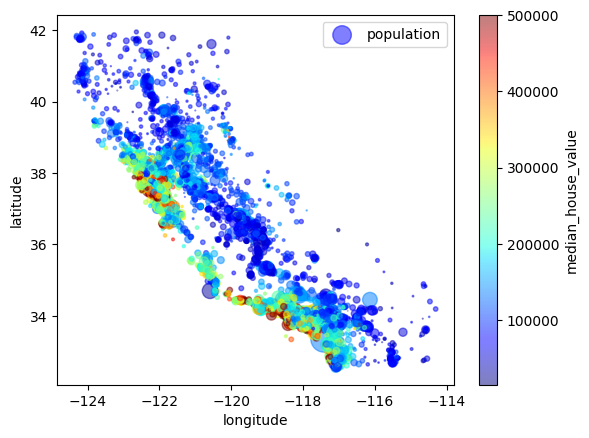

In [14]:
housing_exploring_set.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5,
                           s=housing_exploring_set['population']/100, label='population',
                           c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True
                          )
plt.show()

In [15]:
correlation_matrix = housing_exploring_set.drop('ocean_proximity', axis=1, inplace=False).corr()
correlation_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

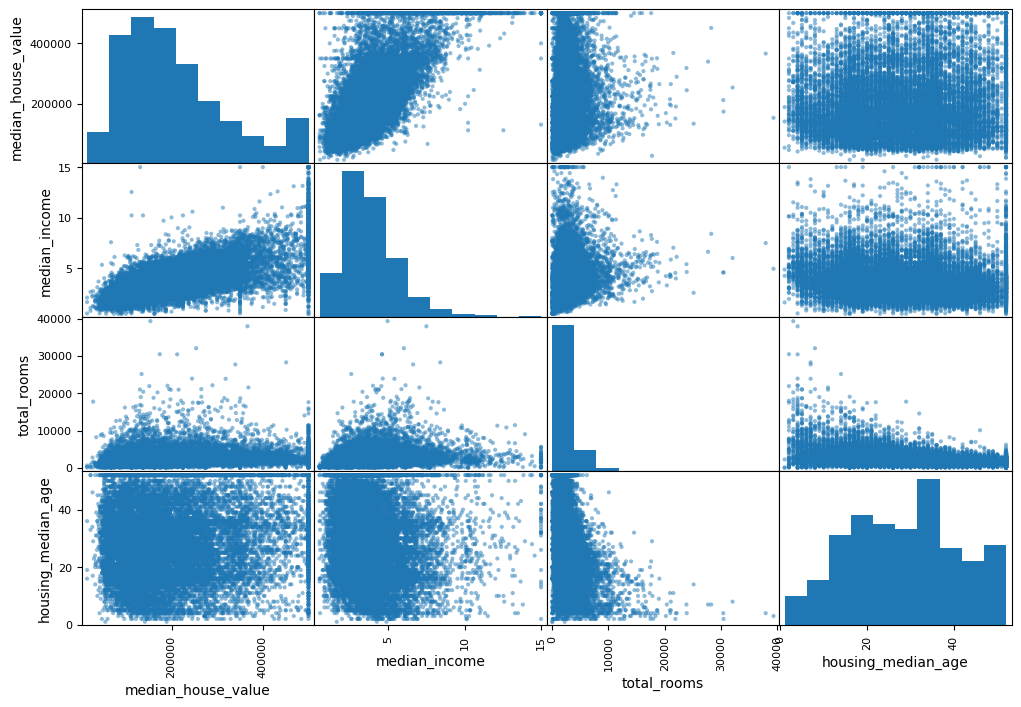

In [16]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
pd.plotting.scatter_matrix(housing_exploring_set[attributes], figsize=(12, 8))
plt.show()

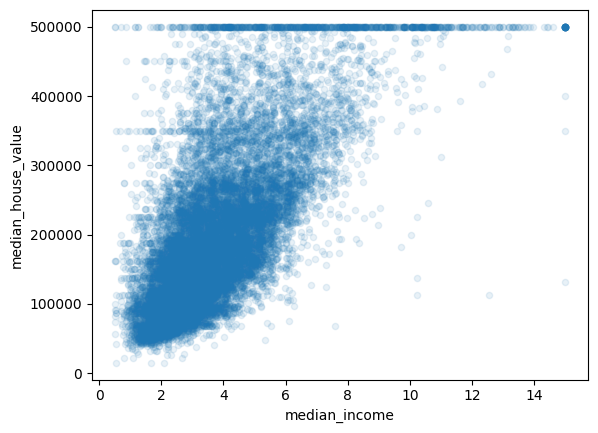

In [17]:
housing_exploring_set.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.show()

### Attributes combinations

In [18]:
housing_exploring_set['rooms_per_household'] = housing_exploring_set['total_rooms'] / housing_exploring_set['households']
housing_exploring_set['bedrooms_per_room'] = housing_exploring_set['total_bedrooms'] / housing_exploring_set['total_rooms']
housing_exploring_set['population_per_household'] = housing_exploring_set['population'] / housing_exploring_set['households']

In [19]:
correlation_matrix = housing_exploring_set.drop('ocean_proximity', axis=1, inplace=False).corr()
correlation_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## Data preparing for Machine Learning Algorithms

In [20]:
housing_train_attributes = strat_train_set.drop('median_house_value', axis=1)
housing_train_labels = strat_train_set['median_house_value'].copy()

In [21]:
imputer = SimpleImputer(strategy='median')
housing_numerical = housing_train_attributes.drop('ocean_proximity', axis=1)
imputer.fit(housing_numerical)
print(imputer.statistics_)
print(housing_numerical.median())

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
longitude             -118.51000
latitude                34.26000
housing_median_age      29.00000
total_rooms           2119.00000
total_bedrooms         433.00000
population            1164.00000
households             408.00000
median_income            3.54155
dtype: float64


In [22]:
housing_numerical_transformed_values = imputer.transform(housing_numerical)
housing_numerical_transformed = pd.DataFrame(housing_numerical_transformed_values, columns=housing_numerical.columns)
housing_numerical_transformed.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,533.939438,1419.687379,497.011810,3.875884
std,2.001828,2.137963,12.574819,2138.417080,410.806260,1115.663036,375.696156,1.904931
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900
25%,-121.800000,33.940000,18.000000,1443.000000,296.000000,784.000000,279.000000,2.566950
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550
75%,-118.010000,37.720000,37.000000,3141.000000,641.000000,1719.000000,602.000000,4.745325
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100


In [23]:
ordinal_encoder = OrdinalEncoder()
housing_categorical = housing_train_attributes[['ocean_proximity']]
housing_categorical_encoded = ordinal_encoder.fit_transform(housing_categorical)
print(housing_categorical_encoded)
print(ordinal_encoder.categories_)

[[1.]
 [4.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [24]:
one_hot_encoder = OneHotEncoder()
housing_categorical_one_hot_encoded = one_hot_encoder.fit_transform(housing_categorical)
print(housing_categorical_one_hot_encoded.toarray())
print(one_hot_encoder.categories_)

[[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


### Custom transformers

In [25]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

In [26]:
combined_attribute_added_encoder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_combined_attributes_encoded = combined_attribute_added_encoder.transform(housing_train_attributes.values)
print(housing_combined_attributes_encoded)

[[-121.46 38.52 29.0 ... 'INLAND' 5.485835694050992 3.168555240793201]
 [-117.23 33.09 7.0 ... 'NEAR OCEAN' 6.927083333333333 2.6236979166666665]
 [-119.04 35.37 44.0 ... 'INLAND' 5.3933333333333335 2.223333333333333]
 ...
 [-122.72 38.44 48.0 ... '<1H OCEAN' 4.1104651162790695
  2.6627906976744184]
 [-122.7 38.31 14.0 ... '<1H OCEAN' 6.297405189620759 2.411177644710579]
 [-122.14 39.97 27.0 ... 'INLAND' 5.477157360406092 3.1725888324873095]]


### Transformation pipelines

In [27]:
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('combinated_attributes_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_numerical_training = numerical_pipeline.fit_transform(housing_numerical)

In [28]:
categorical_pipeline = Pipeline([
    ('ocean_proximity_enconder', OneHotEncoder())
])

In [29]:
numerical_attributes = list(housing_numerical)
categorical_attributes = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('numerical_pipeline', numerical_pipeline, numerical_attributes),
    ('categorical_pipeline', categorical_pipeline, categorical_attributes)
])

housing_prepared = full_pipeline.fit_transform(housing_train_attributes)

## Select and train a model

### Linear regression

In [30]:
linear_regressor = LinearRegression()
linear_regressor.fit(housing_prepared, housing_train_labels)

LinearRegression()

In [31]:
sample_data = housing_train_attributes.iloc[:5]
sample_labels = housing_train_labels.iloc[:5]
sample_data_prepared = full_pipeline.transform(sample_data)
sample_predictions = linear_regressor.predict(sample_data_prepared)
print(list(zip(sample_labels, sample_predictions)))

[(72100.0, 85657.90192014369), (279600.0, 305492.60737487697), (82700.0, 152056.46122455696), (112500.0, 186095.70946094402), (238300.0, 244550.67966088964)]


In [32]:
housing_training_predictions = linear_regressor.predict(housing_prepared)
rmse_error = np.sqrt(mean_squared_error(y_true=housing_train_labels, y_pred=housing_training_predictions))
print(f'RMSE: {rmse_error}')

RMSE: 68627.87390018745


In [33]:
scores = cross_val_score(linear_regressor, housing_prepared, housing_train_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
print(f'Scores: {tree_rmse_scores}')
print(f'Mean: {tree_rmse_scores.mean()}')
print(f'Standard deviation: {tree_rmse_scores.std()}')

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.3282098180634


### Decision tree tegression

In [34]:
decision_tree_regressor = DecisionTreeRegressor()
decision_tree_regressor.fit(housing_prepared, housing_train_labels)

DecisionTreeRegressor()

In [35]:
sample_data = housing_train_attributes.iloc[:5]
sample_labels = housing_train_labels.iloc[:5]
sample_data_prepared = full_pipeline.transform(sample_data)
sample_predictions = decision_tree_regressor.predict(sample_data_prepared)
print(list(zip(sample_labels, sample_predictions)))

[(72100.0, 72100.0), (279600.0, 279600.0), (82700.0, 82700.0), (112500.0, 112500.0), (238300.0, 238300.0)]


In [36]:
housing_training_predictions = decision_tree_regressor.predict(housing_prepared)
rmse_error = np.sqrt(mean_squared_error(y_true=housing_train_labels, y_pred=housing_training_predictions))
print(f'RMSE: {rmse_error}') # 0.0 Bad evaluated, just for learnign purposes

RMSE: 0.0


In [37]:
scores = cross_val_score(decision_tree_regressor, housing_prepared, housing_train_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
print(f'Scores: {tree_rmse_scores}')
print(f'Mean: {tree_rmse_scores.mean()}')
print(f'Standard deviation: {tree_rmse_scores.std()}')

Scores: [73334.1451505  69988.43924538 68810.56279435 71133.43503112
 68847.6624943  77897.74904899 70207.19857395 73999.56846284
 67793.16567037 71764.14246903]
Mean: 71377.60689408153
Standard deviation: 2873.3639369324605


### Random forest regression

In [38]:
random_forest_regressor = RandomForestRegressor()
random_forest_regressor.fit(housing_prepared, housing_train_labels)

RandomForestRegressor()

In [39]:
sample_data = housing_train_attributes.iloc[:5]
sample_labels = housing_train_labels.iloc[:5]
sample_data_prepared = full_pipeline.transform(sample_data)
sample_predictions = random_forest_regressor.predict(sample_data_prepared)
print(list(zip(sample_labels, sample_predictions)))

[(72100.0, 76051.0), (279600.0, 294935.0), (82700.0, 82281.0), (112500.0, 120628.0), (238300.0, 232934.0)]


In [40]:
housing_training_predictions = random_forest_regressor.predict(housing_prepared)
rmse_error = np.sqrt(mean_squared_error(y_true=housing_train_labels, y_pred=housing_training_predictions))
print(f'RMSE: {rmse_error}')

RMSE: 18663.448246768443


In [41]:
scores = cross_val_score(random_forest_regressor, housing_prepared, housing_train_labels, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
print(f'Scores: {tree_rmse_scores}')
print(f'Mean: {tree_rmse_scores.mean()}')
print(f'Standard deviation: {tree_rmse_scores.std()}')

Scores: [51464.57944776 48615.77924321 46756.75106573 52058.3869931
 47172.85568432 51483.13845679 52549.31237752 50241.11918895
 48193.79885799 54381.53282014]
Mean: 50291.72541355006
Standard deviation: 2391.138070056621


### Save models

In [42]:
joblib.dump(linear_regressor, PROJECT_MODELS_PATH / 'housing/experimental/linear_regressor_v1.pkl')
joblib.dump(decision_tree_regressor, PROJECT_MODELS_PATH / 'housing/experimental/decision_tree_regressor_v1.pkl')
joblib.dump(random_forest_regressor, PROJECT_MODELS_PATH / 'housing/experimental/random_forest_regressor_v1.pkl')

### Fine tuning

#### Grid search

In [43]:
param_grid = [
    {
        'n_estimators': [3, 10, 30],
        'max_features': [2, 4, 6, 8]
    },
    {
        'bootstrap': [False],
        'n_estimators': [3, 10],
        'max_features': [2, 3, 4]
    }
]

random_forest_regressor_tuned = RandomForestRegressor()
grid_search = GridSearchCV(
    random_forest_regressor, param_grid, cv=5, scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search.fit(housing_prepared, housing_train_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [44]:
print(grid_search.best_params_)
grid_search.best_estimator_

{'max_features': 6, 'n_estimators': 30}


RandomForestRegressor(max_features=6, n_estimators=30)

In [45]:
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)

63968.369017361765 {'max_features': 2, 'n_estimators': 3}
55637.31143045922 {'max_features': 2, 'n_estimators': 10}
52971.24901701493 {'max_features': 2, 'n_estimators': 30}
60122.0209208188 {'max_features': 4, 'n_estimators': 3}
52608.40959523113 {'max_features': 4, 'n_estimators': 10}
50684.49003990182 {'max_features': 4, 'n_estimators': 30}
59007.851552140586 {'max_features': 6, 'n_estimators': 3}
52048.49836428762 {'max_features': 6, 'n_estimators': 10}
49726.905827255076 {'max_features': 6, 'n_estimators': 30}
58617.38226355185 {'max_features': 8, 'n_estimators': 3}
52297.05846240349 {'max_features': 8, 'n_estimators': 10}
49848.12037895556 {'max_features': 8, 'n_estimators': 30}
62603.49078241485 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54556.74287205402 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60054.584168874084 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52583.63301867035 {'bootstrap': False, 'max_features': 3, 'n_estimators':

In [46]:
feature_importances = grid_search.best_estimator_.feature_importances_
print(feature_importances)

[8.27467408e-02 6.73225816e-02 4.04371650e-02 1.81430594e-02
 1.64193521e-02 1.69346794e-02 1.62908329e-02 3.19994499e-01
 5.28636182e-02 1.06525762e-01 8.32490806e-02 1.34522095e-02
 1.55614973e-01 3.31113630e-05 4.22415697e-03 5.74817868e-03]


In [47]:
extra_attributes = ['rooms_per_hold', 'pop_per_hold', 'bedrooms_per_room']
categorical_encoder = full_pipeline.named_transformers_['categorical_pipeline']
one_hot_encoder_attributes = list(categorical_encoder.steps[0][1].categories_[0])
attributes = numerical_attributes + extra_attributes + one_hot_encoder_attributes
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3199944985832763, 'median_income'),
 (0.1556149730624836, 'INLAND'),
 (0.10652576177433246, 'pop_per_hold'),
 (0.08324908059272784, 'bedrooms_per_room'),
 (0.0827467408205209, 'longitude'),
 (0.0673225816364563, 'latitude'),
 (0.05286361824315817, 'rooms_per_hold'),
 (0.040437165038174315, 'housing_median_age'),
 (0.01814305939859338, 'total_rooms'),
 (0.016934679438094846, 'population'),
 (0.01641935205592833, 'total_bedrooms'),
 (0.016290832864548795, 'households'),
 (0.013452209477310692, '<1H OCEAN'),
 (0.005748178683995562, 'NEAR OCEAN'),
 (0.004224156967446986, 'NEAR BAY'),
 (3.311136295160825e-05, 'ISLAND')]

### Model evaluation

In [49]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
y_predicted = final_model.predict(X_test_prepared)

final_mse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_predicted))
print(f'RMSE: {final_mse}')

RMSE: 47692.73868183871


In [51]:
confidence = 0.95
squared_errors = (y_test - y_predicted) ** 2
confidence_interval = np.sqrt(
    stats.t.interval(
        confidence, len(squared_errors) -1, loc=squared_errors.mean(), scale=stats.sem(squared_errors)
    )
)

print(confidence_interval)

[45712.16678617 49594.27843674]
